### Imports

In [1]:
import cv2
import time

import numpy as np
import matplotlib.pyplot as plt


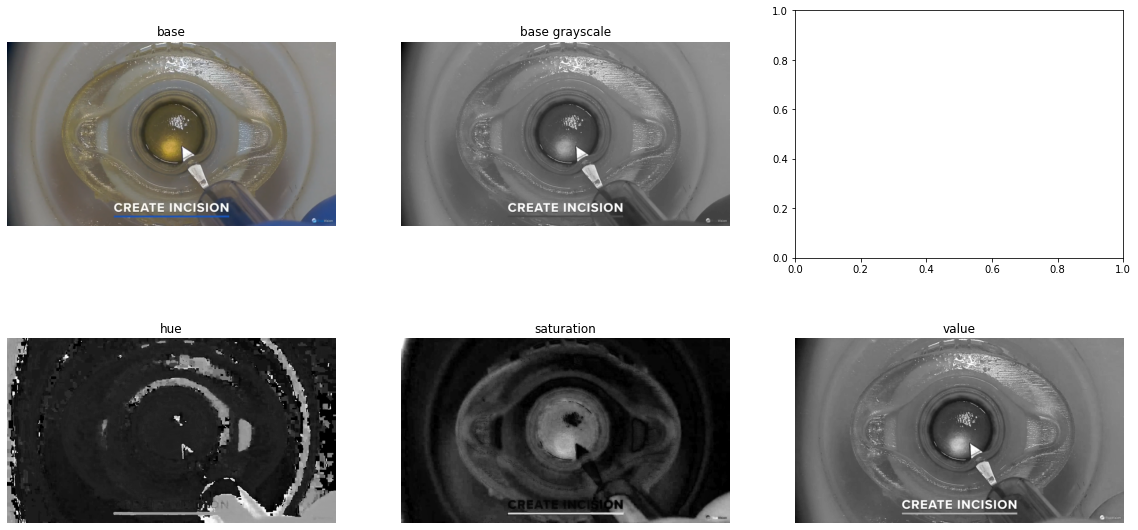

In [18]:
base = cv2.imread('data/artificial/bioniko_rhexis_base.png', cv2.IMREAD_COLOR)
base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:,:,0]
base_saturation = base_hsv[:,:,1]
base_value = base_hsv[:,:,2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)) = plt.subplots(2, 3, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

In [19]:
scale = 0.33333
base_gray_small = cv2.resize(base_gray, (0,0), fx=scale, fy=scale)
base_gray_small.shape

(360, 640)

In [20]:
def get_tuple_point(array_point):
    return tuple(np.round(array_point).astype('int'))

In [21]:
def detect_limbus(gray, return_all=False):
    circles = cv2.HoughCircles(
        cv2.GaussianBlur(255 - gray, ksize=(0,0), sigmaX=2),
        cv2.HOUGH_GRADIENT, dp=1, minDist=1,
        param1=120, param2=40,
        minRadius=gray.shape[0]//10, maxRadius=round(gray.shape[0]//1.5)
    )
    
    if circles is None:
        return None
    
    if return_all:
        return circles[0,:,:]

    return circles[0,0,:2], circles[0,0,2]

### Trying to segment pupil color

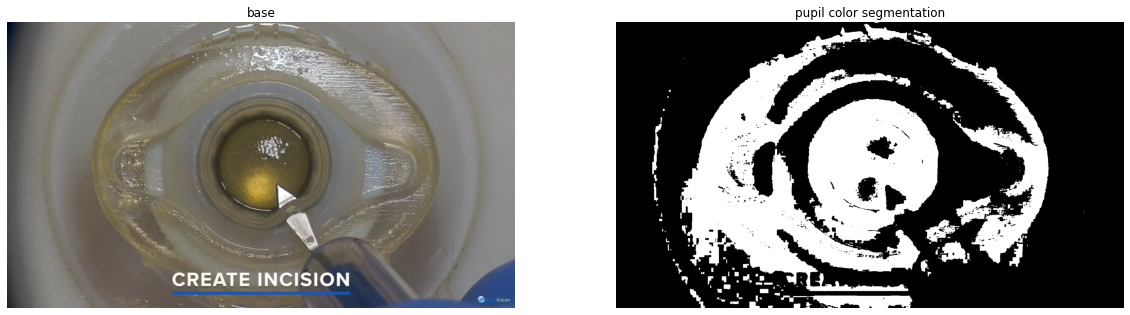

In [45]:
pupil_color_lth = np.array([10, 40, 40])
pupil_color_uth = np.array([30, 180, 180])

base_pupil_color = cv2.inRange(base_hsv, pupil_color_lth, pupil_color_uth)

fig, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title('base')
plots[0].imshow(base_rgb)
plots[0].axis('off')

plots[1].set_title('pupil color segmentation')
plots[1].imshow(base_pupil_color, cmap='gray')
plots[1].axis('off')

plt.show()

In [36]:
base_pupil_color_small = cv2.resize(base_pupil_color, (0,0), fx=scale, fy=scale)
base_pupil_color_small.shape

(360, 640)

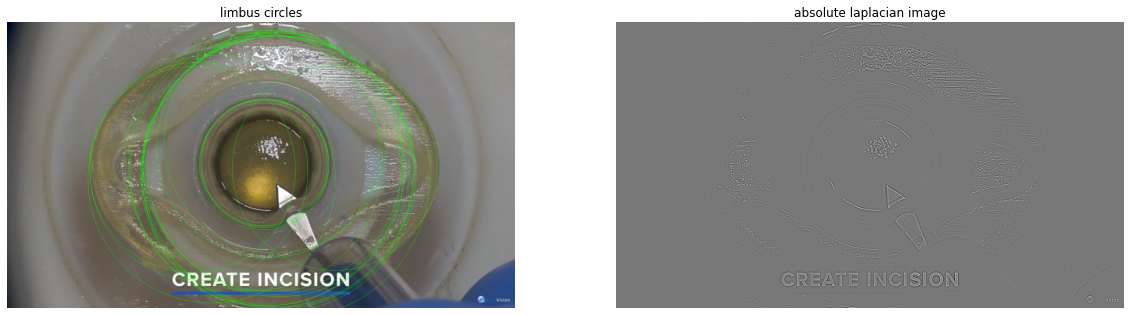

In [37]:
circles = detect_limbus(
    base_pupil_color_small,
    return_all=True
)

base_copy = base_rgb.copy()
for circle in circles[:20,:]:
    limbus_center = circle[:2] / scale
    limbus_radius = circle[2] / scale

#     cv2.drawMarker(base_copy, get_tuple_point(limbus_center), (0,255,0))
    cv2.circle(base_copy, get_tuple_point(limbus_center), round(limbus_radius), (0,255,0), thickness=1)

fig, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title('limbus circles')
plots[0].imshow(base_copy)
plots[0].axis('off')

plots[1].set_title('absolute laplacian image')
# plots[1].imshow(np.abs(cv2.Laplacian(base_gray_small, cv2.CV_16S)), cmap=plt.cm.gray)
plots[1].imshow(cv2.Laplacian(255 - base_gray_small, cv2.CV_16S), cmap=plt.cm.gray)
plots[1].axis('off')

plt.show()

In [38]:
def get_in_out_intensity_diff(grey, center, radius, circle_width_to_radius_ratio=0.04, metric='in_out'):
    mask = np.zeros(grey.shape, dtype=np.byte)
    circle_width = int(circle_width_to_radius_ratio*radius)
    
    cv2.circle(mask, center, radius - (circle_width//2), 1, thickness=circle_width)
    in_intensity = np.mean(grey[mask == 1])
    
    cv2.circle(mask, center, radius + (circle_width//2), 1, thickness=circle_width)
    out_intensity = np.mean(grey[mask == 1])
    
    assert metric in ('in_out', 'out_in'), 'metric %s is not supported' % metric
    
    if metric == 'in_out':
        return out_intensity - in_intensity
    elif metric == 'out_in':
        return in_intensity - out_intensity
    
    return None

In [39]:
circles.shape

(988, 3)

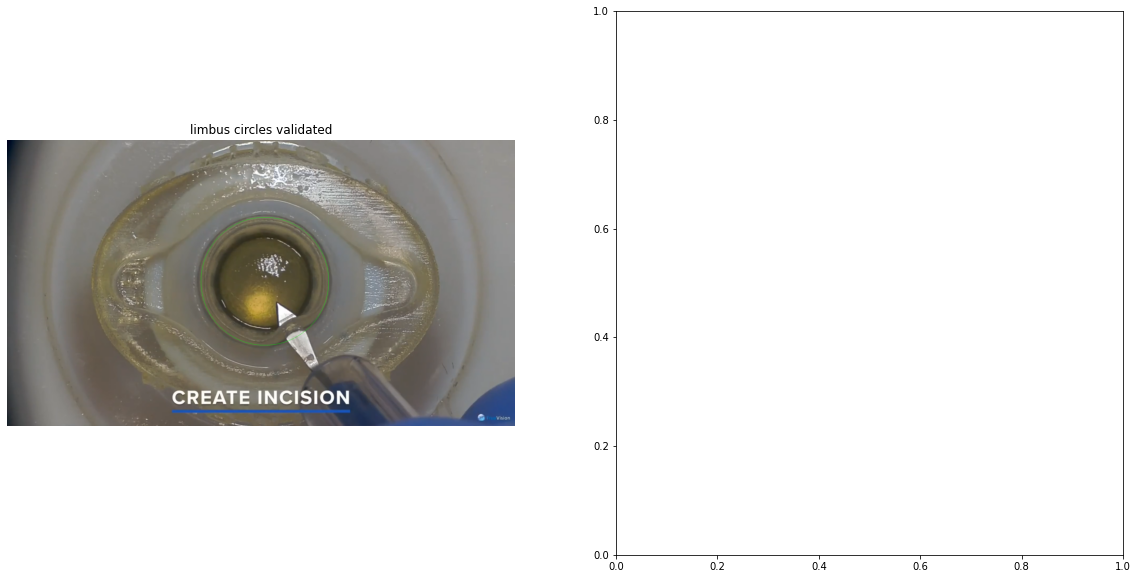

In [44]:
considered_circles = circles[:int(circles.shape[0]*0.3)]
in_out_diff_intensities = np.zeros(len(considered_circles))

for index, circle in enumerate(considered_circles):
        in_out_diff_intensities[index] = get_in_out_intensity_diff(
            base_pupil_color_small,
            tuple(np.around(circle[:2]).astype('int')),
            np.round(circle[2]).astype('int'),
            circle_width_to_radius_ratio=0.1,
            metric='out_in'
        )

best_circle_index = np.argmax(in_out_diff_intensities)
best_circle = considered_circles[best_circle_index]

base_copy = base_rgb.copy()
limbus_center = best_circle[:2] / scale
limbus_radius = best_circle[2] / scale
cv2.circle(base_copy, get_tuple_point(limbus_center), round(limbus_radius), (0,255,0), thickness=1)

fig, plots = plt.subplots(1, 2, figsize=(20,10))
plots[0].set_title('limbus circles validated')
plots[0].imshow(base_copy)
plots[0].axis('off')

plt.show()